# XAI Experiment Data Analysis

## Data Analysis todo list

- ✅ Import and preprocess data
- ✅ Demographics general overview 
- ✅ Performance (accuracy etc.)
  - ✅ AI vs Human vs Human-AI
  - ✅ Compare Human-AI performance among groups
  - ✅ Compare change in performance among groups
- ✅ Willingness to adjust judgments to match the AI system (Agreement percentage, switch percentage and AI preference)
  - ✅ Compare agreement percentage among groups
  - ✅ Compare switch percentage among groups
  - ✅ Compare AI preference among groups
- [ ] Effects of mistakes of the system (FP and FN)
  - [ ] Performance and willingness to adjust at FP and FN compared to other news items
  - [ ] Local evaluation metrics of FP and FN compared to other news items
- [ ] Analysis of open questions
  - [ ] What criteria do you usually use to judge whether a news/article is reliable?
  - [ ] What other information would you like to obtain to better assess the truthfulness of an article?
  - [ ] What functionality would be a good addition?

### Bonus analyses todo list
- [ ] Include journalists and interaction effects
  - [ ] Compare Human-AI performance 
  - [ ] Compare change in performance
  - [ ] Compare agreement percentage
  - [ ] Compare switch percentage
  - [ ] Compare AI preference

In [1]:
import json
import pandas as pd
import requests
import io
from urllib.request import urlopen
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
import pingouin as pg
import scikit_posthocs as sp

In [2]:
%reload_ext autoreload
%autoreload 2

## Import and preprocess data

### Read questionnaire data

In [3]:
df = pd.read_csv('data/data_cleaned.csv')

### Read news items

In [4]:
newsitems = pd.read_csv('../preprocessing/news-items.csv')

In [5]:
newsitems["id"] = newsitems.index + 1
newsitems.index = newsitems.index + 1

In [6]:
# only keep the relevant columns
newsitems = newsitems[["id", "label", "group",
                       "title", "subtitle", "content",
                       "source", "publishing_date", "category",
                       "highlighted_content", "truthfulness", "readability","natural_language_explanation",
                       "is_false_positive", "is_true_negative", "is_qualification"]]

In [7]:
# only keep newsitems from group 2 and newsitems without a group (FP and TN), 
# since only these are used in the experiment
newsitems = newsitems[(newsitems["group"] == 2) | newsitems["group"].isna()]
newsitems = newsitems.drop(columns=["group"])

In [8]:
# create a new column, "is_fake_news", based on if "label" is "FAKE" or "TRUE"
newsitems["is_fake_news"] = newsitems["label"].apply(lambda x: True if x == "FAKE" else False)
newsitems = newsitems.drop(columns=["label"])

In [9]:
# remove percentage sign from truthfulness and convert to int
newsitems["truthfulness"] = newsitems["truthfulness"].apply(lambda x: int(x.replace("%", "")))

In [10]:
newsitems.head()

,id,title,subtitle,content,source,publishing_date,category,highlighted_content,truthfulness,readability,natural_language_explanation,is_false_positive,is_true_negative,is_qualification,is_fake_news
7,7,"Facing unbearable heat, Qatar has begun to air...",2°C: BEYOND THE LIMIT,"Already one of the hottest places on Earth, Qa...",Trustworthy Source,10/16/2019,Environment,"Already one of the hottest places on Earth, Qa...",90,medium,Qatar is one of the hottest countries on earth...,False,False,False,False
8,8,Survival International launches campaign to st...,NaN,Survival International today (Earth Day) launc...,Untrustworthy Source,04/22/2022,Environment,Survival International today (Earth Day) launc...,47,medium,The statement by Survival International that 3...,False,False,False,True
9,9,How Biden's climate plan could limit you to ea...,NaN,President Joe Biden's ambitious plan to slash ...,Untrustworthy Source,04/22/2021,Environment,President Joe Biden's ambitious plan to <span ...,5,easy,President Joe Biden’s climate plans do not inc...,False,False,False,True
10,10,Several Israelis wounded in attack on Jerusale...,Israeli police arrest suspected gunman after a...,Israeli police arrested a suspect in a shootin...,Trustworthy Source,8/14/2022,Crime,"""<mark>Israeli police arrested a suspect in a ...",92,medium,Israeli forces have allegedly been raiding hou...,False,False,True,False
11,11,Young Girl Hitchhiked Through The Middle East ...,NaN,Here’s a shocking and sad story that should be...,Untrustworthy Source,4/14/2016,Crime,"""<span style='background-color:#00FEFE'>Here’s...",21,easy,The article misleads the readers about the tim...,False,False,False,True


### Filtering out assumed cheaters

Assume that participants who did answer at least 5 out of 6 control questions correctly were paying attention and gave valid answers.

In [11]:
# participants who did not get 2 points in the qualification shouldn't be considered
# journalists don't have a qualification score, so they should be kept
df = df[(df["POINTS.qualification"].isna()) | (df['POINTS.qualification'] == 2)]

In [12]:
# journalists don't have a main score, so they should be kept
df = df[(df["POINTS.main"].isna()) | (df["POINTS.main"] >= 5)]

In [13]:
# filter out journalists who didn't reach enough points in the merged task
df = df[df["POINTS"] >= 7]

In [14]:
def lay(data):
    return data[data["JOURNALIST"] == False]

In [15]:
# only lay participants are considered
df = lay(df)

## Demographics

In [16]:
# get columns which start with "demographics"
demographics_cols = [col for col in df.columns if col.startswith('demographics')]
demographics_cols
# country and nationality are not relevant, since the study was conducted in the US

['demographics.age',
 'demographics.country',
 'demographics.education',
 'demographics.employment',
 'demographics.gender',
 'demographics.income',
 'demographics.nationality']

In [17]:
df["demographics.age"].value_counts(normalize=True).sort_index() * 100

18-20           3.940887
21-29          25.862069
30-39          38.423645
40-49          22.906404
50-59           6.896552
60-or-older     1.970443
Name: demographics.age, dtype: float64

In [18]:
df["demographics.education"].value_counts(normalize=True) * 100
# university degree is the most common education level, this is surprising

university         54.187192
high-school        39.655172
no-degree           2.709360
secondary           2.216749
upper-secondary     1.231527
Name: demographics.education, dtype: float64

In [19]:
df["demographics.employment"].value_counts(normalize=True) * 100

salaried-employee    36.453202
self-employed        31.773399
unemployed           13.546798
student               9.852217
other                 6.403941
civil-servant         0.738916
retiree-pensioner     0.738916
apprentice            0.492611
Name: demographics.employment, dtype: float64

In [20]:
income_vc = df["demographics.income"].value_counts(normalize=True)
print("less-than-20000-usd", income_vc["less-than-20000-usd"] * 100)
print("20000-34999-usd", income_vc["20000-34999-usd"] * 100)
print("35000-49999-usd", income_vc["35000-49999-usd"] * 100)
print("50000-74999-usd", income_vc["50000-74999-usd"] * 100)
print("75000-99999-usd", income_vc["75000-99999-usd"] * 100)
print("over-100000-usd", income_vc["over-100000-usd"] * 100)
print("no-answer", income_vc["no-answer"] * 100)

less-than-20000-usd 14.285714285714285
20000-34999-usd 17.733990147783253
35000-49999-usd 10.83743842364532
50000-74999-usd 20.44334975369458
75000-99999-usd 12.068965517241379
over-100000-usd 13.546798029556651
no-answer 11.083743842364532


In [21]:
df["demographics.gender"].value_counts(normalize=True) * 100

female     63.546798
male       35.714286
diverse     0.738916
Name: demographics.gender, dtype: float64

## Define Kruskal-Wallis test function

In [22]:
def highlight(data, highlight_any=False, alpha=0.05):
    columns = ["p-val", "p-unc", "p-corr", "p"]

    if highlight_any:
        columns = data.columns
        
    return data.style.apply(lambda x: ["text-decoration: underline" if isinstance(v, (int, float)) and v < alpha and c in columns else "" for c, v in zip(x.index, x)], axis=1)

In [23]:
def perform_kruskal_with_posthoc(df, col, print_results=True, between="FEATURE"):
    kruskal_test = pg.kruskal(df, dv=col, between=between, detailed=True)
    kruskal_pval = kruskal_test["p-unc"].values[0]

    # uses Mann–Whitney U test under the hood
    posthoc = pg.pairwise_tests(df, dv=col, between=between, parametric=False, padjust="holm")

    # posthoc = sp.posthoc_dunn(df, val_col=col, group_col=between, p_adjust="holm")

    if print_results:
        print("Column name:", col)
        print("kruskal_pval", kruskal_pval, "\n")
        print(posthoc, "\n")
        print(df.groupby(between)[col].describe()[["mean", "std"]], "\n")

    return kruskal_test, posthoc, df.groupby(between)[col].describe()[["count", "mean", "std"]]

## Performance

### AI vs Human vs Human-AI

How does the AI system perform compared to humans and the combination of humans and AI? 

The task is to judge whether a news item is fake news or not, thus this is a binary classification problem. Since both the AI and participants are asked to rate the news items on a 0-100 scale, we use a threshold of 50, where ratings of <50 are treated as predicted fake news and ratings >=50 are treated as predicted truthful news.

The metrics for the AI are calculated over the 8 news items. Metrics are calculated for each participant separately over the presented news items (e.g. a participant correctly judged 6 out of 8 news items, thus the accuracy for the participant is 6/8 = 0.75). Human-AI performance is measured after presenting the AI rating to the participants, this is also calculated for each participant separately.

### Calculate performance metrics of the AI system

In [24]:
RATING_THRESHOLD = 50

newsitems["is_fake_news_pred"] = newsitems["truthfulness"] < RATING_THRESHOLD

In [25]:
newsitems["is_fake_news"].value_counts()

True     5
False    3
Name: is_fake_news, dtype: int64

Since the dataset is unbalanced (5 fake news items and 3 truthful news items), we also use metrics that are more robust to unbalanced datasets than accuracy, such as precision, recall, F1-score and ROC AUC. Furthermore, a Brier score is calculated to measure the accuracy of the predicted probabilities.

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, log_loss

ai_accuracy = accuracy_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_precision = precision_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_recall = recall_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_f1 = f1_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_roc_auc = roc_auc_score(newsitems["is_fake_news"], 1 - (newsitems["truthfulness"] / 100))
ai_brier_score = brier_score_loss(
    newsitems["is_fake_news"],
    newsitems["truthfulness"] / 100, 
    pos_label=0
)

ai_performance_df = pd.DataFrame({
  "accuracy": [ai_accuracy],
  "precision": [ai_precision],
  "recall": [ai_recall],
  "f1": [ai_f1],
  "roc_auc_score": [ai_roc_auc],
  "brier_score": [ai_brier_score]
})

ai_performance_df

,accuracy,precision,recall,f1,roc_auc_score,brier_score
0,0.75,0.8,0.8,0.8,0.666667,0.254462


### Calculate performance metrics of the participants and Human-AI teams

In [27]:
def calculate_human_metrics(row):
    y_true = newsitems["is_fake_news"]
    y_pred_human = []
    y_pred_human_prob = []
    y_pred_human_ai = []
    y_pred_human_ai_prob = []

    for i in y_true.index:
        y_pred_human.append(row[f"newsitem.{i}.rating-before-xai"] < 50)
        y_pred_human_prob.append(row[f"newsitem.{i}.rating-before-xai"] / 100)
        y_pred_human_ai.append(row[f"newsitem.{i}.rating-after-xai"] < 50)
        y_pred_human_ai_prob.append(row[f"newsitem.{i}.rating-after-xai"] / 100)

    for i, _id in enumerate(y_true.index):
        # will be used later for comparing news items
        row[f"newsitem.{_id}.human-before-correct"] = y_true[_id] == y_pred_human[i]
        row[f"newsitem.{_id}.human-after-correct"] = y_true[_id] == y_pred_human_ai[i]

    human_accuracy = accuracy_score(y_true, y_pred_human)
    human_precision = precision_score(y_true, y_pred_human, zero_division=0)
    human_recall = recall_score(y_true, y_pred_human)
    human_f1 = f1_score(y_true, y_pred_human)
    human_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_prob))
    human_brier_score = brier_score_loss(y_true, y_pred_human_prob, pos_label=0)

    human_ai_accuracy = accuracy_score(y_true, y_pred_human_ai)
    human_ai_precision = precision_score(y_true, y_pred_human_ai, zero_division=0)
    human_ai_recall = recall_score(y_true, y_pred_human_ai)
    human_ai_f1 = f1_score(y_true, y_pred_human_ai)
    human_ai_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_ai_prob))
    human_ai_brier_score = brier_score_loss(y_true, y_pred_human_ai_prob, pos_label=0)

    row["human_accuracy"] = human_accuracy
    row["human_precision"] = human_precision
    row["human_recall"] = human_recall
    row["human_f1"] = human_f1
    row["human_roc_auc_score"] = human_roc_auc
    row["human_brier_score"] = human_brier_score

    row["human_ai_accuracy"] = human_ai_accuracy
    row["human_ai_precision"] = human_ai_precision
    row["human_ai_recall"] = human_ai_recall
    row["human_ai_f1"] = human_ai_f1
    row["human_ai_roc_auc_score"] = human_ai_roc_auc
    row["human_ai_brier_score"] = human_ai_brier_score

    return row

df = df.apply(calculate_human_metrics, axis=1)

#### Compare AI vs Human vs Human-AI (without journalists)

To compare the performance of the AI system to the performance of the participants and Human-AI teams, we average the metrics across the participants.

In [28]:
# show mean human scores, mean human_ai scores and ai scores in one dataframe
human_scores = df[[
    "human_accuracy", 
    "human_precision", 
    "human_recall", 
    "human_f1", 
    "human_roc_auc_score",
    "human_brier_score",
]].copy()

human_ai_scores = df[[
    "human_ai_accuracy", 
    "human_ai_precision", 
    "human_ai_recall", 
    "human_ai_f1", 
    "human_ai_roc_auc_score",
    "human_ai_brier_score",
]].copy()

human_scores = human_scores.rename(columns=lambda x: x.replace("human_", ""))
human_ai_scores = human_ai_scores.rename(columns=lambda x: x.replace("human_ai_", ""))

human_scores = human_scores.mean()
human_ai_scores = human_ai_scores.mean()


In [29]:
scores_df = pd.DataFrame({
  "ai": ai_performance_df.iloc[0],
  "human": human_scores,
  "human_ai": human_ai_scores,
})

scores_df

,ai,human,human_ai
accuracy,0.750000,0.730911,0.818350
precision,0.800000,0.849748,0.897223
recall,0.800000,0.706404,0.809360
f1,0.800000,0.749796,0.840796
roc_auc_score,0.666667,0.806076,0.884975
brier_score,0.254462,0.181032,0.134820


In [30]:
scores_plot_df = pd.melt(
  scores_df.drop(["brier_score"]).reset_index(), 
  id_vars=["index"], 
  value_vars=["ai", "human", "human_ai"]
)

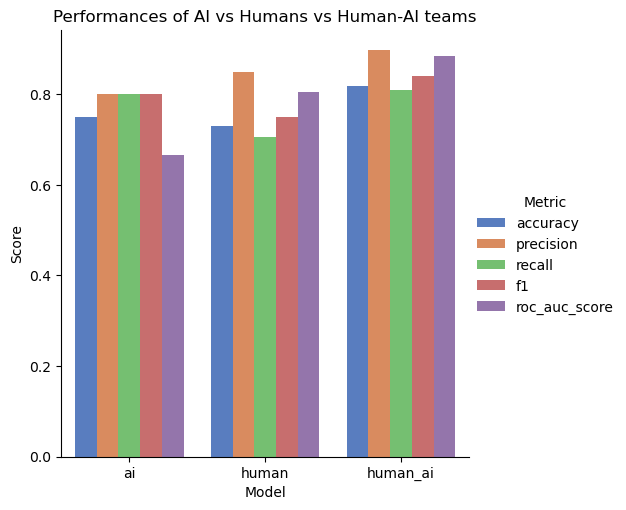

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

c = sns.catplot(x="variable", y="value", hue="index", data=scores_plot_df,  palette="muted", kind="bar")
plt.title("Performances of AI vs Humans vs Human-AI teams")
plt.ylabel("Score")
plt.xlabel("Model")
c._legend.set_title("Metric")

#### Human vs Human-AI

We use a Wilcoxon signed-rank test to determine if there is a significant difference in participants' performance before and after seeing the AI scores (and explanations).

In [32]:
wilcoxon_test = pg.wilcoxon(df["human_accuracy"], df["human_ai_accuracy"])
highlight(wilcoxon_test)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,5429.500000,two-sided,0.000000,-0.694207,0.345625


In [33]:
df[["human_accuracy", "human_ai_accuracy"]].describe().loc[["mean", "std"]]

,human_accuracy,human_ai_accuracy
mean,0.730911,0.818350
std,0.158179,0.137579


A significant difference in accuracy before and after seeing the AI score (p < 0.01). The average human accuracy before is 0.730911. The average human accuracy after (= Human-AI accuracy) is 0.818350. (AI accuracy is 0.750000)

#### AI vs Human-AI

We use a Wilcoxon signed-rank test to determine if there is a significant difference between AI performance and Human-AI performance.

In [34]:
ai_accuracy_df = pd.DataFrame({"accuracy": [ai_performance_df["accuracy"][0]] * len(df)})


In [35]:
wilcoxon_test = pg.wilcoxon(ai_accuracy_df["accuracy"], df["human_ai_accuracy"])
highlight(wilcoxon_test)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,8505.000000,two-sided,0.000000,-0.588415,0.318966


In [36]:
print(f"Mean Human-AI accuracy: {df[['human_ai_accuracy']].mean().values[0]}")
print(f"Mean AI accuracy: {ai_performance_df[['accuracy']].mean().values[0]}")

Mean Human-AI accuracy: 0.8183497536945813
Mean AI accuracy: 0.75


The performance of AI-Human teams is significantly higher than the one of the AI system alone (p < 0.01). The average AI accuracy is 0.750000. The average Human-AI accuracy is 0.818350.

### Compare Human-AI performance among groups (v1 vs v2 vs v3)

We use a Kruskal-Wallis H-test to determine if there is a significant difference in the accuracy of the Human-AI teams among the groups.

In [37]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "human_ai_accuracy", print_results=False);

In [38]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,0.320474,0.851942


In [39]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.815789,0.132876
explanations,133.0,0.822368,0.150921
salient,140.0,0.816964,0.129341


A high p-value (0.851942) indicates that there is no significant difference in performance among the groups.

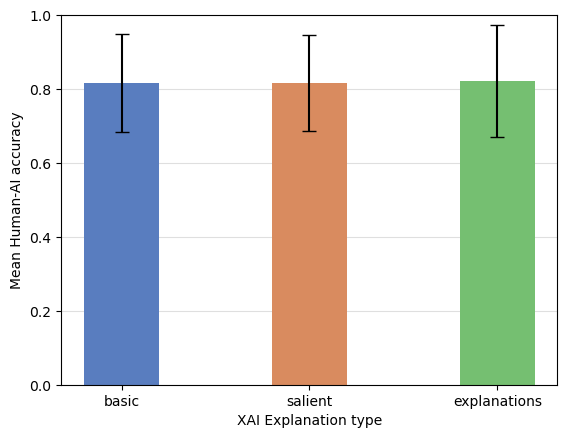

In [40]:
col = "human_ai_accuracy"

accuracy_data = df.groupby("FEATURE")[col].describe()[["mean", "std"]].reset_index()
accuracy_data["FEATURE"] = pd.Categorical(accuracy_data["FEATURE"], categories=["basic", "salient", "explanations"], ordered=True)
accuracy_data = accuracy_data.sort_values("FEATURE")

fig, ax = plt.subplots()
sns.barplot(x="FEATURE", y="mean", data=accuracy_data, ax=ax, palette="muted", width=.4)
ax.set_ylabel("Mean Human-AI accuracy")
ax.set_xlabel("XAI Explanation type")
ax.set_ylim(0, 1)
ax.errorbar(x=accuracy_data["FEATURE"], y=accuracy_data["mean"], yerr=accuracy_data["std"], fmt='none', c='black', capsize=5)
# have a grid on the y-axis
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)

### Compare the change in performance among groups (v1 vs v2 vs v3)

In [41]:
df["accuracy_change"] = df["human_ai_accuracy"] - df["human_accuracy"]

In [42]:
df["accuracy_change"].describe().loc[["count", "mean", "std"]]

count    406.000000
mean       0.087438
std        0.152568
Name: accuracy_change, dtype: float64

On average, the accuracy of the participants increased by 0.087438 after seeing the AI score. We use a Kruskal-Wallis H-test to determine if there is a significant difference in the change in performance of the participants among the groups.

In [43]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "accuracy_change", print_results=False);

In [44]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,5.674691,0.058581


In [45]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.106203,0.139751
explanations,133.0,0.084586,0.168935
salient,140.0,0.072321,0.146963


There is no significant difference in change in performance among the groups.

## Willingness to adjust judgments to match the AI system

We use three metrics to measure the willingness of the participants to adjust their judgments to match the AI system:
- Agreement percentage: percentage of news items in which the participant’s final prediction agreed with the AI’s prediction (adapted from [1] and [2])
- Switch percentage: percentage of news items in which the participant revised their predictions to match the model’s predictions (adapted from [1] and [2])
- AI-preference: a number between 0 and 1 that indicates the degree to which the participant prefers the AI’s prediction over their own original prediction. This is defined for individual news item ratings of one participant. It is defined as:

$$
ai\_preference = 
\begin{cases}
1 & \text{if } rating_{before} = ai\_rating \text{ and } ai\_rating = rating_{after} \\
0 & \text{if } rating_{before} = ai\_rating \text{ and } ai\_rating \neq rating_{after} \\
\min(1, \max(0, \frac{rating_{after} - rating_{before}}{ai\_rating - rating_{before}})) & \text{otherwise}
\end{cases}
$$

[1]: https://dl.acm.org/doi/10.1145/3290605.3300509 
[2]: https://dl.acm.org/doi/10.1145/3351095.3372852

### Calculate willingness to adjust metrics

In [46]:
def agrees_with_ai(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating = row[f"newsitem.{newsitem_id}.rating-after-xai"]
    return (human_rating < 50) == (ai_rating < 50)

def switched_ratings(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating_before = row[f"newsitem.{newsitem_id}.rating-before-xai"]
    human_rating_after = row[f"newsitem.{newsitem_id}.rating-after-xai"]
    
    return ((human_rating_before < 50) != (human_rating_after < 50)
            ) and ((human_rating_after < 50) == (ai_rating < 50))

def calculate_ai_preference(row, newsitem_id):
    rating_before_col = f"newsitem.{i}.rating-before-xai"
    rating_after_col = f"newsitem.{i}.rating-after-xai"
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]

    if row[rating_before_col] == ai_rating:
        if ai_rating == row[rating_after_col]:
            return 1
        else:
            return 0
    else:
        return min(1, max(0, (row[rating_after_col] - row[rating_before_col]) / (ai_rating - row[rating_before_col])))
    
for i in range(7, 15):
    df[f"newsitem.{i}.agrees-with-ai"] = df.apply(lambda row: agrees_with_ai(row, i), axis=1)
    df[f"newsitem.{i}.switched-to-ai"] = df.apply(lambda row: switched_ratings(row, i), axis=1)
    df[f"newsitem.{i}.ai-preference"] = df.apply(lambda row: calculate_ai_preference(row, i), axis=1)

In [47]:
agrees_with_ai_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('agrees-with-ai')]
switched_to_ai_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('switched-to-ai')]
ai_preference_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('ai-preference')]

# calculate average AI preference over all newsitems
df["agrees-with-ai"] = df[agrees_with_ai_cols].mean(axis=1)
df["switched-to-ai"] = df[switched_to_ai_cols].mean(axis=1)
df["ai-preference"] = df[ai_preference_cols].mean(axis=1)

We use Kruskal-Wallis H-tests to determine if there is a significant difference in the willingness of the participants to adjust their judgments among the groups (based on the three metrics). When the test shows a significant difference, we use Mann-Whitney U tests with a Holm correction to determine which groups differ significantly.

### Agreement percentage (v1 vs v2 vs v3)

In [48]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "agrees-with-ai", print_results=False);

In [49]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,10.511823,0.005217


In [50]:
highlight(posthoc)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,FEATURE,basic,explanations,False,False,7219.000000,two-sided,0.006941,0.013883,holm,-0.321403
1,FEATURE,basic,salient,False,False,9418.000000,two-sided,0.864163,0.864163,holm,0.014156
2,FEATURE,explanations,salient,False,False,11140.000000,two-sided,0.003469,0.010407,holm,0.345823


In [51]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.736842,0.146182
explanations,133.0,0.781015,0.127258
salient,140.0,0.734821,0.138618


There is a significant difference in **agreement percentage** among the groups (Kruskal-Wallis H-test, p=0.005217), the posthoc tests show that the agreement percentage is significantly higher in v3 than in v1 (Mann-Whitney U test, p=0.013883) or v2 (Mann-Whitney U test, p=0.010407). There is no significant difference between the agreement percentage of groups v1 and v2 (Mann-Whitney U test, p=0.864163).

### Switch percentage (v1 vs v2 vs v3)

In [52]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "switched-to-ai", print_results=False);

In [53]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,10.108654,0.006382


In [54]:
highlight(posthoc)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,FEATURE,basic,explanations,False,False,7899.500000,two-sided,0.123774,0.198357,holm,-0.181025
1,FEATURE,basic,salient,False,False,10357.500000,two-sided,0.099179,0.198357,holm,0.217095
2,FEATURE,explanations,salient,False,False,11323.000000,two-sided,0.001584,0.004753,holm,0.403911


In [55]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.223684,0.178809
explanations,133.0,0.256579,0.183554
salient,140.0,0.186607,0.161836


There is a significant difference in **switch percentage** among the groups (Kruskal-Wallis H-test, p=0.006382), the posthoc tests show that switch percentage is significantly higher in v3 than in v2 (Mann-Whitney U test, p=0.004753). There is no significant difference between the switch percentage of groups v1 and v2 (Mann-Whitney U test, p=0.198357) or v1 and v3 (Mann-Whitney U test, p=0.198357).

### AI-preference (v1 vs v2 vs v3)

In [56]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "ai-preference", print_results=False);

In [57]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,18.061552,0.000120


In [58]:
highlight(posthoc)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,FEATURE,basic,explanations,False,False,7104.000000,two-sided,0.005545,0.011090,holm,-0.325073
1,FEATURE,basic,salient,False,False,10309.500000,two-sided,0.125494,0.125494,holm,0.160249
2,FEATURE,explanations,salient,False,False,11998.000000,two-sided,0.000038,0.000113,holm,0.482682


In [59]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.509299,0.205499
explanations,133.0,0.576165,0.204720
salient,140.0,0.475976,0.209125


There is a significant difference in **AI-preference** among the groups (Kruskal-Wallis H-test, p=0.00012), the posthoc tests show that AI-preference is significantly higher in v3 than in v1 (Mann-Whitney U test, p=0.011090) or v2 (Mann-Whitney U test, p=0.000113). There is no significant difference between the AI-preference of groups v1 and v2 (Mann-Whitney U test, p=0.125494).

In [60]:
pg.cronbach_alpha(df[["agrees-with-ai", "switched-to-ai", "ai-preference"]])

(0.8186625030487245, array([0.786, 0.847]))

As the three metrics aim to measure similar concepts, we calculate Cronbach's alpha to determine if the metrics are consistent. The Cronbach's alpha is 0.818663, which indicates that the metrics are consistent.

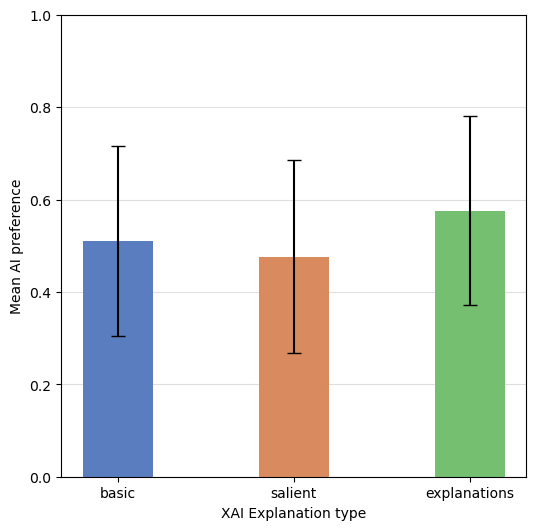

In [61]:
ai_pref_data = df.groupby("FEATURE")["ai-preference"].describe()[["mean", "std"]].reset_index()
ai_pref_data["FEATURE"] = pd.Categorical(ai_pref_data["FEATURE"], categories=["basic", "salient", "explanations"], ordered=True)
ai_pref_data = ai_pref_data.sort_values("FEATURE")

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="FEATURE", y="mean", data=ai_pref_data, ax=ax, palette="muted", width=.4)
ax.set_ylabel("Mean AI preference")
ax.set_xlabel("XAI Explanation type")
ax.set_ylim(0, 1)
ax.errorbar(x=ai_pref_data["FEATURE"], y=ai_pref_data["mean"], yerr=ai_pref_data["std"], fmt='none', c='black', capsize=5)
# have a grid on the y-axis
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)

## Effects of mistakes of the system

In [62]:
# TODO

In [63]:
local_eval_data = []

for ind, row in df.iterrows():
    for i in range(7, 15):
        local_eval_data.append(
            {
                "newsitem": i,
                "classified-correctly": row[f"newsitem.{i}.system-evaluation.classified-correctly"],
                # "explanations-comprehensible-and-help-assess": row[f"newsitem.{i}.system-evaluation.explanations-comprehensible-and-help-assess"],
                # "indications-useful": row[f"newsitem.{i}.system-evaluation.indications-useful"],
                # "understand-what-system-does": row[f"newsitem.{i}.system-evaluation.understand-what-system-does"],
                # "xai-features-useful": row[f"newsitem.{i}.system-evaluation.xai-features-useful"],
                # "human-before-correct": row[f"newsitem.{i}.human-before-correct"],
                # "human-after-correct": row[f"newsitem.{i}.human-after-correct"],
                # "ai-preference": row[f"newsitem.{i}.ai-preference"],
                # "switched-to-ai": row[f"newsitem.{i}.switched-to-ai"],
            }
        )

local_eval_df = pd.DataFrame(local_eval_data)


In [64]:
local_eval_means = local_eval_df.groupby("newsitem").mean().reset_index()

local_eval_means =  pd.melt(local_eval_means, id_vars="newsitem", var_name="measure")
local_eval_means

,newsitem,measure,value
0,7,classified-correctly,6.152709
1,8,classified-correctly,5.738916
2,9,classified-correctly,6.137931
3,10,classified-correctly,6.325123
4,11,classified-correctly,5.871921
5,12,classified-correctly,6.492611
6,13,classified-correctly,3.677340
7,14,classified-correctly,4.027094


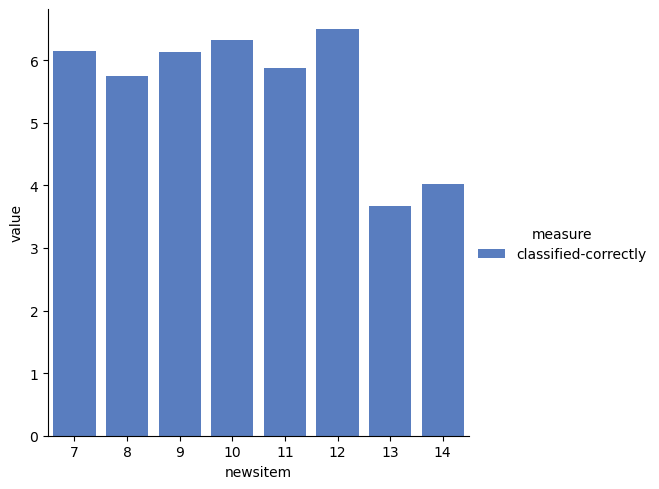

In [65]:
sns.catplot(x="newsitem", y="value", hue="measure", data=local_eval_means,  palette="muted", kind="bar")

# show the numbers on the x axis for values 13 and 14 in red


plt.show();

## Analysis of open questions

In [66]:
# TODO